In [31]:
import sys
import clipboard
import gc
import PIL, numpy as np, cv2
from PIL.ImageGrab import grab as screenshot
from PIL import Image
sys.path.append('C:\\Users\\Administrator\\source\\repos\\mycvtools\\x64\\Release\\')
import mycvtools
import importlib
import os

In [2]:
ss = screenshot((200, 395, 400, 495))
ssa = np.array(ss)

In [3]:
mycvtools.average_color(ssa)

(48, 43, 49)

In [4]:
mycvtools.mask_background(ssa)

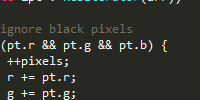

In [5]:
ss

In [6]:
mycvtools.average_color(ssa)

(132, 125, 133)

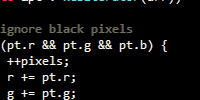

In [7]:
PIL.Image.fromarray(ssa)

In [19]:
def fulllistdir(fp):
    return [os.path.join(fp, f) for f in os.listdir(fp)]

In [93]:
fp = "C:\\Users\\Administrator\\Dropbox\\Python\\jpnotebooks\\other\\ngu\\images"
images = []

ncols = 5
maxrow = 0
heights = [0, 0]
row = 0
for i, file in enumerate(os.listdir(fp), 1):
    if file == ("inventory.bmp"): continue
    img = cv2.imread(os.path.join(fp, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #mycvtools.mask_background(img)
    images.append(img)
    row += img.shape[0]
    if img.shape[1] > heights[-1]:
        heights[-1] = img.shape[1]
    if i % ncols == 0:
        if row > maxrow:
            maxrow = row
        row = 0
        heights.append(0)
        
for i in range(1, len(heights)):
    heights[i] += heights[i - 1]

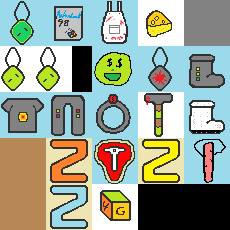

In [94]:
aimg = Image.new('RGB', (maxrow, heights[-1]))
lastw = 0
lasth = 0
for i, img in enumerate(images):
    pimg = Image.fromarray(img, "RGB")
    aimg.paste(pimg, ((i % 5) * lastw, heights[i // 5]))
    lastw = pimg.width
aimg

In [92]:
for img in images:
    print(mycvtools.average_color(img))

(51, 73, 146)
(135, 150, 146)
(184, 175, 175)
(183, 37, 162)
(128, 128, 129)
(123, 39, 150)
(123, 39, 150)
(133, 30, 177)
(114, 81, 80)
(101, 100, 102)
(113, 102, 110)
(101, 98, 100)
(89, 81, 81)
(107, 73, 100)
(173, 173, 173)
(0, 0, 0)
(176, 45, 99)
(177, 68, 80)
(176, 21, 168)
(124, 64, 64)
(0, 0, 0)
(114, 163, 153)
(158, 37, 135)


In [101]:
(2000*7 - 1000 * 5 - 4000 ) / 3500

1.4285714285714286